# Automated image caption generation using Transfer Learning and LSTM 

## Overview

Image captioning is the task of providing a natural language description to an image. The architecture behind such an application involves a Convolutional Neural Network to encode the input image in the form of numerical vectors and a decoder network to generate a descriptive text sequence based on the objects identified in the image. Inspired by Neural Machine Translation, sophisticated models using attention-based Recurrent Neural Networks have shown path-breaking results in caption generation.

In this project, I'm implementing an image captioning model by experimenting with pre-trained ConvNets and an attention-based LSTM RNN. 



*   Dataset used: Flickr8k
*   Framework: PyTorch
*   Key Libraries: Pandas, Numpy, torchvision
*   Pre-trained Model: RESNET152


## Implementation

Importing the essential libraries



In [ ]:
# Importing the essential libraries
import os
from os import listdir
import random
import zipfile as Z
import pickle
import time

# torch libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

import pandas as pd
import numpy as np
import seaborn as sns
from string import punctuation
import matplotlib.image as mpimg
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# Others
from collections import Counter
import string
import re

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
torch.cuda.is_available()

True

In [ ]:
from torchtext import data, datasets
TEXT = data.Field()
tokenizer = data.get_tokenizer('toktok') # toktok tokenizer function for tokenizing captions

**Downloading data files from personal G-drive folder**

In [ ]:
from google.colab import drive
drive.mount("./drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./drive


In [ ]:
# Importing and extracting files from G-Drive
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/capstone/Flickr8k_Dataset.zip", 'r')
zip_ref.extractall('/content/sample_data/Flickr8k')
zip_ref.close()


zip_ref = zipfile.ZipFile("/content/drive/My Drive/capstone/Flickr8k_text.zip", 'r')
zip_ref.extractall('/content/sample_data/Flickr8k')
zip_ref.close()

In [ ]:
# Key file paths
root = "/content/sample_data/Flickr8k/"
image_dir = root + 'Flicker8k_Dataset/'
caption_file = 'Flickr8k.token.txt'


Let's define all the utility functions here

1)  bind_captions() **Param(s):** 'captions' 

2)  text_cleaning() **Param(s):** 'raw_caption'

*   remove_punctuation()
*   remove_single_character()
*   remove_numeric()

3)  vocabulary() **Param(s):** 'cleaned captions' 

4)  Visualization functions


*   denormalize() **Param(s):** 'image'
*   show_batch() **Param(s):** 'dataloader'
*   plot_loss() **Param(s):** 'losses from LSTM training'
*   loadImage() **Param(s):** 'image_path', 'transformations to be applied'
*   show_sample_image() **Param(s):**'image'
*   List item

5)  get_default_device()

6) to_device() **Param(s):** 'data', 'device'

7) generate_caption() **Param(s):** 'image tensor' , 'actual image'

8) get_caption() **Param(s):** 'image', 'indices of the generated captions'



In [ ]:
###########################################################  Fundamental functions #####################################################################
# Assign start and end tokens to captions for processing
def bind_captions(captions):
  start = '<start> '
  end = ' <end>'
  # Add start and end tokens to the captions
  for ix, row in enumerate(captions['caption']):
    captions['caption'][ix] = start + row + end
  return

# If any filename doesn't have a proper .jpg extension, we mark it as Invalid filename
def invalid_filename_check(captions):
  for filenames in captions["image"]:
    found = re.search("(.(jpg)$)", filenames)
    if (found):
        pass
    else:
        return(filenames)
        break

############################################################## Text Preprocessing functions ###########################################################

# To remove punctuations
def remove_punctuation(raw_caption):
    clean_text = re.sub(r'[^\w\s]','',raw_caption)
    return(clean_text)


# To remove single characters such as 'a'
def remove_single_character(raw_caption):
    clean_text = re.sub(r"\b[a-zA-Z]\b", "", raw_caption)
    return(clean_text)

# To remove numeric values
def remove_numeric(raw_caption):
  clean_text = re.sub(r'\d+', '', raw_caption)
  return(clean_text)

def text_cleaning(raw_caption):
  ''' the main function for text preprocessing and cleaning 
      Called functions:
          - remove_punctuation()
          - remove_single_character()
          - remove_numeric()
      Standard argument: caption
      '''
  # Convert text to lower case. Strip trailing spaces
  raw_caption = raw_caption.lower().strip()

  # Remove punctuations
  clean_cap = remove_punctuation(raw_caption)

  # Remove single characters
  clean_cap = remove_single_character(clean_cap)

  # Remove numeric characters from captions
  clean_cap = remove_numeric(clean_cap)
  
  return clean_cap

############################################################### Building vocabulary ###########################################################
# Build a vocabulary with the cleaned captions

def vocabulary(captions):
  ''' Arg: Cleaned captions '''
  vocab = []
  for caption in captions['caption'].values:
    vocab.extend(caption.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

############################################################## Visualization functions #######################################################

def denormalize(image):
  #  Denormalize image to view the augmentation 
    image = image.numpy().transpose(1, 2, 0) 
    mean = stats[0]
    stdd = stats[1]
    image = (image * stdd + mean).clip(0,1)
    plt.axis('off')
    plt.imshow(image)
    print('Size of the image :', image.shape)
    return 

def show_batch(dl):

  """ Function to visualize one batch of images from the dataloader in a grid format """

  for images, captions, lengths in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:16], nrow=4, pad_value = 4).permute(1, 2, 0))
    break

def plot_loss(loss_lstm):
  ''' Function to plot the losses '''
  x = list(range(1,7))
  plt.figure()
  sns.lineplot(x=x, y=loss_lstm)
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Loss vs epoch for LSTM")

def loadImage(image_path, transform=None):
  ''' Function to load image during evaluation step '''
  image = Image.open(image_path)
  if transform is not None:
      image = transform(image).unsqueeze(0)
  return image

def show_sample_image(image):
    img = Image.open(image_dir + image)
    rgb_image = pil2tensor(img)
    plt.axis('off')
    plt.imshow(rgb_image.numpy().transpose(1, 2, 0))


################################################################# Device loading functions ###########################################

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


############################################################### Miscellaneous functions ############################################

def generate_caption(img_tensor, actual_img):
  ''' Function to generate captions during evaluation mode '''
  image = img_tensor.to(device)
  feature = encoder(image)
  caption_img = decoder.sample(feature)
  caption_img = caption_img[0].cpu().numpy()
  sentence, references = get_caption(actual_img, caption_img)
  return

def get_caption(image, caption_ix):
  '''Stand alone function to test on individual images from test samples'''
  sampled_caption = []
  for word_id in caption_ix:
    word = map.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
      break
  sentence = ' '.join(sampled_caption[1:-1])
  references = descriptions[image]
  print('\033[1m Generated Caption: \033[0m', sentence)
  print('\033[1m Actual caption(s): \033[0m')
  print('\n'.join(references))
  # Show image
  print('\n')
  show_sample_image(image)
  return sentence, references


In [ ]:
# Reusable function to display a sample of images alongside their captions
def show_image_and_captions(samples, captions, n_cols, out_flag):
  count = 1
  fig = plt.figure(figsize = (15,15))

  # Read the image from file
  for a in range(len(samples)):
    img_path = image_dir + samples[a]
  
    # Open the image from 'images' folder
    pil_image = Image.open(img_path)
  
    # Convert PIL image to torch tensor
    rgb_img = pil2tensor(pil_image)
  
    # Fetch the captions for the sample images 
    if out_flag:
      if a == 0:
        targets = captions_img1
      elif a == 1:
        targets = captions_img2
      else:
        targets = captions_img3
    else:
      targets = list(captions["caption"].loc[captions["image"] == samples[a]].values)

    # Create a subplot grid 
    ax = fig.add_subplot(len(samples), n_cols, count, xticks=[], yticks=[] )
    ax.imshow(rgb_img.numpy().transpose(1, 2, 0))

    # increment sub-plot index
    count += 1
   
    ax = fig.add_subplot(len(samples), n_cols, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(targets))

    # Place captions by the side of the image
    for i, val in enumerate(targets):
      if out_flag:
        for i, caption in enumerate(targets):
          if a == 0:
            ax.text(-0.1,i,'BLEU score: ' + str(bleu4_img1[i][1]) + ', ' + caption,fontsize=20, wrap=True)
          elif a == 1:
            ax.text(-0.1,i,'BLEU score: ' + str(bleu4_img2[i][1]) + ', ' + caption,fontsize=20, wrap=True)
          else:
            ax.text(-0.1,i,'BLEU score: ' + str(bleu4_img3[i][1]) + ', ' + caption,fontsize=20, wrap=True)
      else:
       ax.text(0,i,val,fontsize=15)
        

    # increment sub-plot index
    count += 1

    if out_flag:
        ax = fig.add_subplot(len(samples),3,count)
        actual_captions = list(descriptions[samples[a]])

        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(actual_captions))
        # Place captions by the side of the image
        for i, caption in enumerate(actual_captions):
          # Place captions by the side of the image
          ax.text(2.5,i,caption,fontsize=20, wrap=True)

        # increment sub-plot index
        count += 1

  return

# Initial Analysis of the Dataset

First of all how many images do we have in total?


In [ ]:
images = os.listdir(image_dir)
n_images = len(images)
print('Total number of images available in the Flickr8k dataset: ', n_images)

Total number of images available in the Flickr8k dataset:  8091



## Q1: How does the captions file look like?

In [ ]:
# A look into captions file
captions = pd.read_csv(root + caption_file, sep='\t', header=None, names = ['image_id', 'caption'])
captions.head()

image_id                                            caption
0  1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg#1              A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg#2   A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg#3  A little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg#4  A little girl in a pink dress going into a woo...

Dissecting the image_id column into two with '#' as the separator.

In [ ]:
captions[['image', 'caption_id']] = captions['image_id'].str.split('#',expand = True)
captions.head()

image_id  ... caption_id
0  1000268201_693b08cb0e.jpg#0  ...          0
1  1000268201_693b08cb0e.jpg#1  ...          1
2  1000268201_693b08cb0e.jpg#2  ...          2
3  1000268201_693b08cb0e.jpg#3  ...          3
4  1000268201_693b08cb0e.jpg#4  ...          4

[5 rows x 4 columns]

## Q2: How many observations are available in the 'captions' dataframe?

In [ ]:
# Number of records
captions.shape
print('Number of records in captions dataframe: ', captions.shape[0])


Number of records in captions dataframe:  40460


## Q3: How many captions per image? Some statistics on the captions.

In [ ]:
# Number of images per caption ID
c = Counter([values for values in captions['caption_id']])
print(c)

Counter({'0': 8092, '1': 8092, '2': 8092, '3': 8092, '4': 8092})


**Observation** 

There are five captions per image. 


Let's check some sample images.

In [ ]:
# Helper functions from transforms library
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

The dimension of the image is 500 x 332


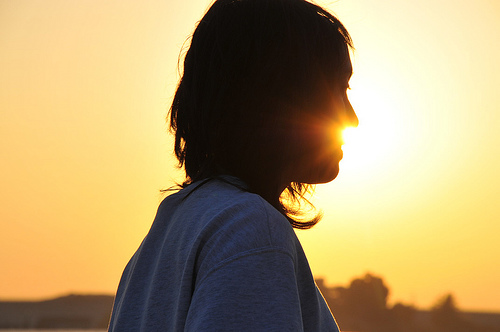

In [ ]:
# Sample image - first image in the folder
imagesList = listdir(image_dir)
img = Image.open(image_dir + imagesList[0] )
width, height = img.size
print("The dimension of the image is", width, "x", height)
img

The dimension of the image is 500 x 333


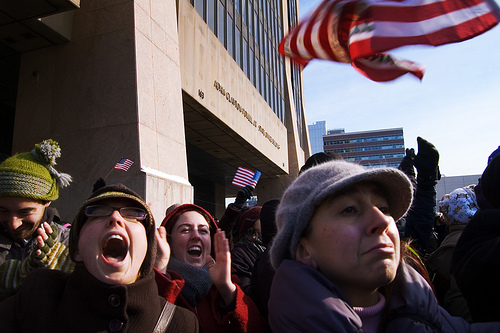

In [ ]:
# Randomly pick a file from the folder to view
random_filename = random.choice([
    x for x in os.listdir(image_dir)
    if os.path.isfile(os.path.join(image_dir, x))
])
img = Image.open(image_dir + random_filename)
width, height = img.size
print("The dimension of the image is", width, "x", height)
img

Randomly selecting 5 images to display along with their respective captions.

In [ ]:
# Randomly sample 5 images 
samples = random.sample(imagesList, 5)
samples

['95734035_84732a92c1.jpg',
 '516214924_c2a4364cb3.jpg',
 '3497106366_d1a256e723.jpg',
 '2863349041_5eba6e3e21.jpg',
 '3208032657_27b9d6c4f3.jpg']

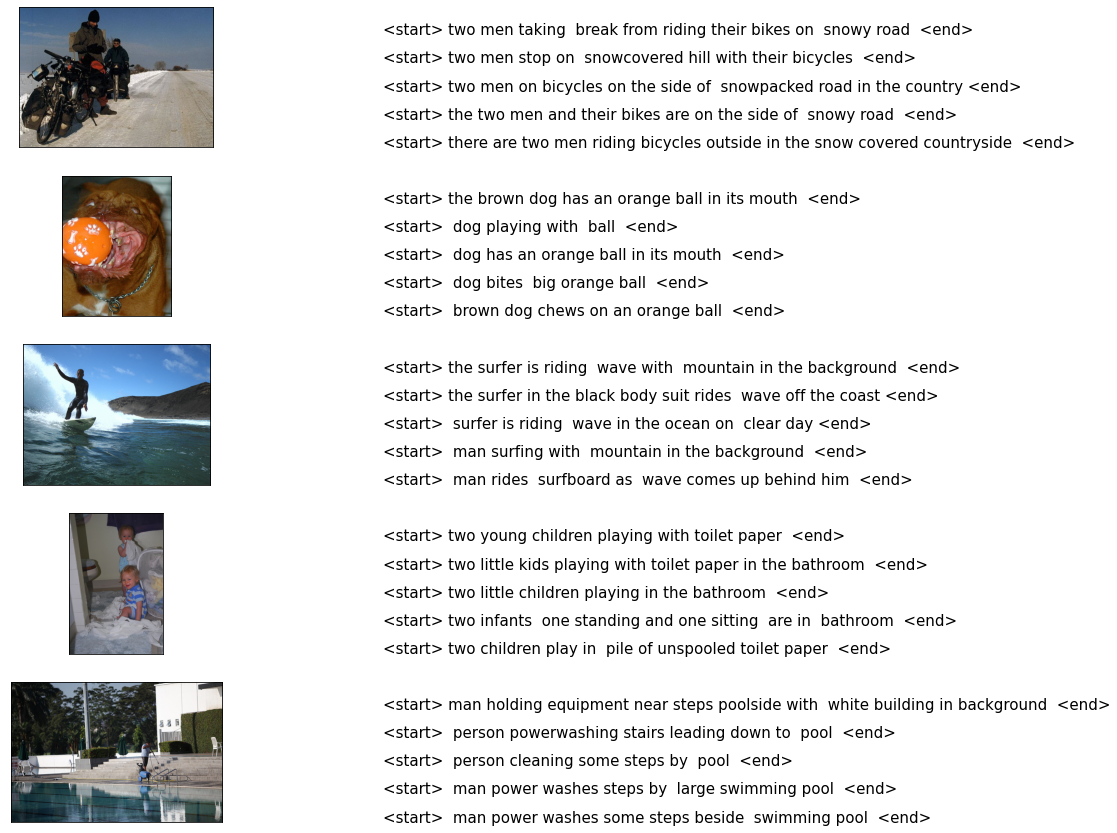

In [ ]:
# Display the samples alongside their respective captions

show_image_and_captions(samples, captions, 2, out_flag = False)

**Examining the captions data more**

### Distribution of the length of captions

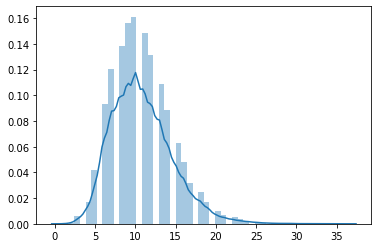

In [ ]:
# Distribution of captions
custom_punct = punctuation.replace("'", "")
cap_len = []
for c in captions.caption:
  n_words = len(c.translate(str.maketrans('','', custom_punct)).split())    #output_str = re.sub('[^A-Za-z0-9]+', ' ', input_str)
  cap_len.append(n_words)

sns.distplot(cap_len);
captions['n_words'] = cap_len

In [ ]:
# Maximum and minimum length of captions
max_length = max(cap_len)
min_length = min(cap_len)

print('Maximum number of words in the captions: ', max_length)
print('Minimum number of words in the captions: ', min_length)


Maximum number of words in the captions:  36
Minimum number of words in the captions:  1


We see from the distribution that we have the minimum number of words in the captions is 1. Let's check how many such captions are there and what are the respective images.

In [ ]:
captions[captions['n_words'] == 1]

image_id caption  ... caption_id n_words
9310   2428275562_4bde2bc5ea.jpg#0       A  ...          0       1
33365  3640443200_b8066f37f6.jpg#0       a  ...          0       1

[2 rows x 5 columns]

In [ ]:
# Corresponding index values
indx = [val for val in captions[captions['n_words'] == 1].index.astype(int)]
print(indx)

[9310, 33365]


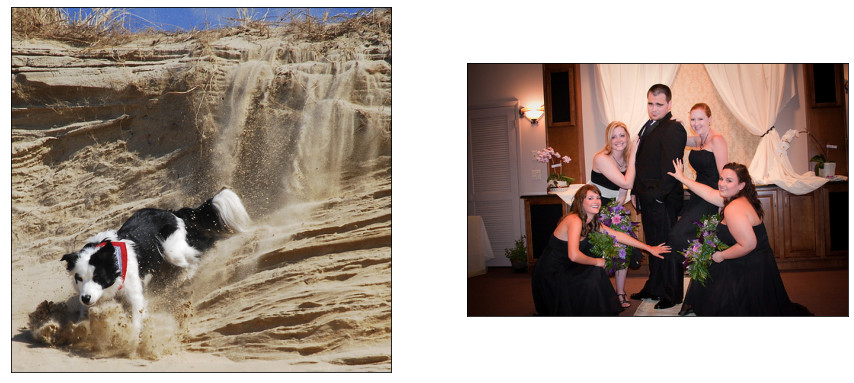

In [ ]:
# Checking the corresponding images
img_id = []
for i in captions[captions['n_words'] == 1]['image']:
  img_id.append(i)

fig, axes = plt.subplots(1, 2, figsize = (15,15), squeeze=False )
axes = axes.ravel()

for i in range(2):
  axes[i].set_xticks([]); axes[i].set_yticks([])
  if i == 0:
    img = Image.open(image_dir + img_id[0])
    rgb_image = pil2tensor(img)
    axes[i].imshow(rgb_image.numpy().transpose(1, 2, 0))
    
  else:
    img = Image.open(image_dir + img_id[1])
    rgb_image = pil2tensor(img)
    axes[i].imshow(rgb_image.numpy().transpose(1, 2, 0))



It appears that we have a couple of captions that have inadequate information pertaining to the image they correspond to. We will eliminate them from our model building due to their low degree of usefulness.

Let's also investigate if there are issues in the image_ids.

**Examining the image IDs in the captions file for errors**

In [ ]:
# Use invalid_filename_check() to find out errors in image filenames

fname = invalid_filename_check(captions)
print("Error file: {}".format(fname))

Error file: 2258277193_586949ec62.jpg.1


In [ ]:
# Verify if the invalid image ID in the captions dataframe has an actual image file 
if fname in os.listdir(image_dir):
  print('True')
elif fname[:-2] in os.listdir(image_dir):
  print('File exists in the name ', fname[:-2])
else:
  print('File\033[1m \'{}\' \033[0;0mdoesn\'t exist' .format(fname))


File '2258277193_586949ec62.jpg.1' doesn't exist


### Data cleaning: Removal of invalid rows from 'captions' dataframe

In [ ]:
# Now add the indices of this invalid image_id to the previous created 'indx' list
for i in captions[captions['image'] == fname].index:
  indx.append(i)

print(indx)

[9310, 33365, 6730, 6731, 6732, 6733, 6734]


In [ ]:
# Removing the records correspodning to the indices
captions = captions.drop(index=indx, axis = 1)

# Reset the index after completing drop
captions = captions.reset_index(drop = True)

# Verify the shape of the captions file now - Should be 40453 rows 
print(captions.shape)


(40453, 5)


In [ ]:
# Number of unique images in the dataset
print('Number of unique images in the dataset: ', captions['image'].nunique())

n_captions_per_img = captions.groupby(['image'], as_index=False)['caption_id'].count().iloc[:,1].unique()

print('Number of captions per image:', n_captions_per_img)

Number of unique images in the dataset:  8091
Number of captions per image: [5 4]


**Observations**

1) Captions file has two columns: image_id and caption

2) Total number of observations in the captions dataset is 40,460

3) Number of unique images available = 8091

4) Average number of captions per image: 5

5) Average length of captions (in number of words) = 10. Maximum length of the captions = 36 (words)

6) Images are of varying dimensions. So, we have to essentially apply a transformation technique to reshape the image according to the model we choose to apply.

7) After cleaning the data, the final number of observations are **40453 with 8091 unique valid images**.




# Caption pre-processing

Clean captions and create the base vocabulary for the decoder part to work on.


We also bind start and end tokens to mark the beginning and end of captions.



**Step 1:** 

We start with creating a dictionary with 'keys' as image_id and values as respective 'captions'.

In the sample above, we observe instances where there are single characters such as "**\<apostrophe>s**". These characters affect our main vocabulary as they don't carry meaningful information during caption generation. In the next step, we perform text cleaning which involves,



1.   Punctuation removal
2.   Removing single characters such as 's', 'a', etc.
3.   Removing numbers

The final step here would be to create a list or counter of all the unique meaningful words in our captions vocabulary.



In [ ]:
# Perform text cleaning 
for ix, cap in enumerate(captions.caption.values):
  clean_cap = text_cleaning(cap)
  captions['caption'].iloc[ix] = clean_cap


In [ ]:
# Create a dictionary with image_id as key and respective clean captions as values
descriptions = dict()

for row in (captions.loc[:, ['image', 'caption']]).itertuples():
  if row[1]  in descriptions:
    descriptions[row[1]].append(row[2])
  else:
    descriptions[row[1]] = list()
    descriptions[row[1]].append(row[2])
    
print('Number of keys in the dictionary: ', len(descriptions))

Number of keys in the dictionary:  8091


In [ ]:
# Getting the first key-value pair for verification
next(iter(descriptions.items()))

('1000268201_693b08cb0e.jpg',
 [' child in  pink dress is climbing up  set of stairs in an entry way ',
  ' girl going into  wooden building ',
  ' little girl climbing into  wooden playhouse ',
  ' little girl climbing the stairs to her playhouse ',
  ' little girl in  pink dress going into  wooden cabin '])

In [ ]:
# Bind all captions with start and end tokens
bind_captions(captions)


In [ ]:
# Retain only image_id and caption column going forward
captions_df = captions[['image', 'caption']]
print('Shape of the duplicate captions datafrme: ', captions_df.shape)
captions_df.head()


Shape of the duplicate captions datafrme:  (40453, 2)


image                                            caption
0  1000268201_693b08cb0e.jpg  <start>  child in  pink dress is climbing up  ...
1  1000268201_693b08cb0e.jpg   <start>  girl going into  wooden building  <end>
2  1000268201_693b08cb0e.jpg  <start>  little girl climbing into  wooden pla...
3  1000268201_693b08cb0e.jpg  <start>  little girl climbing the stairs to he...
4  1000268201_693b08cb0e.jpg  <start>  little girl in  pink dress going into...

In [ ]:
vocabulary = vocabulary(captions_df)

# Create a pickle file for storing the vocabulary file
with open(root + 'vocab.pkl', 'wb') as f:
  pickle.dump(vocabulary, f)

Vocabulary Size : 8770


This **'vocabulary'** is a list of all the unique words in the captions (including the **\<start>** and **\<end>** tokens).

**Note**: Pre-trained word-embeddings such as GloVe and Word2Vec can also be used instead of generating the vocabulary file from the captions.

In [ ]:
# Word count in the vocabulary
c = Counter(vocabulary)

In [ ]:
# List of words with frequency greater than 3
words= []
#The code below iterates over the Counter and stores words with frequency > 3 in a separate list
for k,v in c.items():
  if v > 3:
    words.append(k)


In [ ]:
# Number of words in the list now
len(words)

3424

To account for unknown words and padding, we'll have to add two tokens **\<pad>** and **\<unk>** to the vocabulary.


**Note**: Padding is required because we need all the sentences to be of the same length before processing them through LSTM.

In [ ]:
# Now adding '<pad>' and '<unk>' to the list of words
append_list = ['<pad>', '<unk>']

words = append_list + words

#words.extend(append_list)
len(words)

3426

In [ ]:
# Let's see how this list looks like
words[:10]

['<pad>',
 '<unk>',
 '<start>',
 'start',
 'child',
 'in',
 'pink',
 'dress',
 'is',
 'climbing']

Now that we have done some preliminary investigation on the training dataset, we are going to lay out the overall model architecture.

<figure>
<center>
<img src='https://docs.google.com/uc?export=download&id=1tr7T-urBqLG26bBC_yTldEK_7-WaKfDh' />
<figcaption>End to end Encoder-Decoder architecture for Image captioning</figcaption></center>
</figure>

Here for the encoder architecture, we are using RESNET152 pre-trained image recognition model and eliminating the last two layers to retain just until the vector representation of our input image(s).


The Decoder architecture is going to be an LSTM RNN.

In a sequence model, we will need to convert words in the caption to numbers. So, we here we define a helper class for mapping unique words in the vocabulary to a number.


In [ ]:
# Build the word to index and index to word mapping
class mapping(object):
    """Simple vocabulary mapping wrapper which maps every unique word to an integer ID and vice versa. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """ Adding word to the vocabulary """
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
# Create an instance of the mapping and adding all the words
map = mapping()

for i in words:
  map.add_word(i)

len(map)

3426

So what is the purpose of this mapping? Let me illustrate this with an example below.

We convert a piece of text (appended with <start> and <end> tokens just like our captions) into a set of numbers.

In [ ]:
# Consider a piece of text
text = '<start> the girl is playing with the barbie doll <end>'

[map(tokens) for tokens in text.split()]


[2, 23, 16, 7, 34, 35, 23, 1, 1493, 15]

Now our index2word and word2index mappings are done. We have altogether 3895 words in our mapping (which include \<start>, \<end>, \<pad> and \<unk>)

Now let's get the images ready.

In [ ]:
# Function for fetching images from the folder

def fetch_images(path, ds):
  '''Function to pull up the train, test and validation images from the image folder
        Parameters:
            path : the image folder
            ds : the category of images to be pulled (train, test, validation)'''
  img_set = []

  for i in os.listdir(path):
    if i in ds:
      img_set.append(i)

  return(img_set)

In [ ]:

# training set
train_fname = root + 'Flickr_8k.trainImages.txt'
train_ds = list(open(train_fname, 'r').read().strip().split('\n'))
train_imgs = fetch_images(image_dir, train_ds)
print('Number of training data: ', len(train_imgs))

# validation set
valid_fname =  root + 'Flickr_8k.devImages.txt'
valid_ds = list(open(valid_fname, 'r').read().strip().split('\n'))
valid_imgs = fetch_images(image_dir, valid_ds)
print('Number of validation data: ', len(valid_imgs))

# test set
test_fname =  root + 'Flickr_8k.testImages.txt'
test_ds = list(open(test_fname, 'r').read().strip().split('\n'))
test_imgs = fetch_images(image_dir, test_ds)
print('Number of test data: ', len(test_imgs))


Number of training data:  6000
Number of validation data:  1000
Number of test data:  1000


In [ ]:
valid_imgs[0]

captions_df[captions_df['image'] == '2090339522_d30d2436f9.jpg']

image                                            caption
4865  2090339522_d30d2436f9.jpg  <start>  man in  green hat is someplace up hig...
4866  2090339522_d30d2436f9.jpg  <start>  man in  green hat is taking  self por...
4867  2090339522_d30d2436f9.jpg    <start>  man in  hat at  scenic overlook  <end>
4868  2090339522_d30d2436f9.jpg  <start>  man wearing  green canvas hat with  d...
4869  2090339522_d30d2436f9.jpg  <start> man with green hate and sunglasses on ...

In [ ]:
test_imgs[0]

captions_df[captions_df['image'] == '2436081047_bca044c1d3.jpg']

image                                            caption
9409  2436081047_bca044c1d3.jpg  <start>  girl dismounts from  swing as high as...
9410  2436081047_bca044c1d3.jpg  <start>  girl in  pink shirt jumping out of  m...
9411  2436081047_bca044c1d3.jpg  <start>  little girl wearing  pink shirt jumps...
9412  2436081047_bca044c1d3.jpg  <start>  young girl jumps off  playground swin...
9413  2436081047_bca044c1d3.jpg  <start> the young girl in the pink shirt and b...

Let's define the transforms for the images.

Transformations applied:
1.  Resize images into 224x224
2.  Random crop with padding of 4 and padding_mode as 'reflect'
3.  Random Horizontal flip
4.  Convert to tensor
5.  Normalize images according to the pre-defined standard that is set for applying RESNET.

These transformations are a good way of augmenting the training data.


In [ ]:
# Defining the transforms
# stats obtained from PyTorch official tutorial for transfer learning

stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# Crop size matches the input dimensions expected by the pre-trained ResNet
preprocess_train_image = transforms.Compose([ 
    transforms.Resize(256),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'), 
    transforms.RandomHorizontalFlip(p = 0.6),
    transforms.ToTensor(),
    transforms.Normalize(*stats, inplace=True)]) # Using ResNet standards


valid_txms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats, inplace=True)])


A quick experiment about how this transformation would take effect. 

We randomly pick an image, apply the transform and denormalize the transformed image to see how it appears after data augmentation.


The dimension of the image is 351 x 500


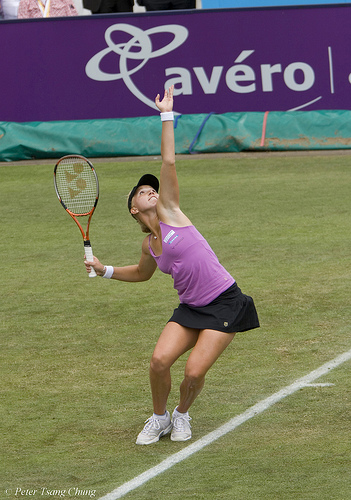

In [ ]:
# Randomly picked image
random_filename = random.choice([
    x for x in os.listdir(image_dir)
    if os.path.isfile(os.path.join(image_dir, x))
])
img = Image.open(image_dir + random_filename)
width, height = img.size
print("The dimension of the image is", width, "x", height)
img

In [ ]:
# Check the transformation on the random image
input_image = Image.open(image_dir + random_filename)
input_tensor = preprocess_train_image(input_image)

Size of the image : (224, 224, 3)


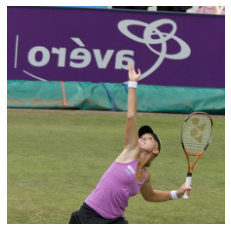

In [ ]:
denormalize(input_tensor)

**Observation**:
Input image of size 351x500 has been transformed to a standard required for RESNET. Dimensions being 224 x 224x 3 where '3' is the number of channels 'RGB'.

In [ ]:
# Create the Flickr8k class
class FlickrDataset(torch.utils.data.Dataset):
  def __init__(self, df, vocab, image_dir, transform = None):
    self.df = df
    self.image_dir = image_dir
    self.vocab = vocab
    self.transform = transform

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
            idx = idx.tolist()
    
    img_id = self.df['image'][idx]
    caption = self.df['caption'][idx]

    img_path = os.path.join(self.image_dir, img_id)
    image = Image.open(open(img_path, 'rb'))

    # Apply transformation to the image
    if self.transform is not None:
      image = self.transform(image)

    # Convert caption to indexes from the vocab file - eg. shown below this code chunk
    tokens = tokenizer(caption)     # toktok tokenizer; Whitespacetokenizer(NLTK) or plain caption.split() will also work
    # print(tokens)
    caption = []
    caption.extend([self.vocab(token) for token in tokens])
    caption = torch.Tensor(caption)
    return image, caption
  
  def __len__(self):
    return len(self.df)


Here's a small example of how tokenization can work in **torchtext**, **NLTK** and plain **split()**.

In [ ]:
test_string = '<start>  child in  pink dress is climbing up  set of stairs in an entry way  <end>'
print('original string: \n' + test_string + '\n')

# Using torchtext
from torchtext import data, datasets
TEXT = data.Field()
tokenizer = data.get_tokenizer(tokenizer = 'toktok') # toktok tokenizer function
print('tokenized string using torchtext: \n',tokenizer(test_string))
print('\n')

# NLTK WhitespaceTokenizer
from nltk.tokenize import WhitespaceTokenizer
ws_tok = WhitespaceTokenizer()
print('tokenized string using whitespacetokenizer: \n', ws_tok.tokenize(test_string))
print('\n')


# Pandas text.split() tokenization
print('Default split() tokenization result: \n', test_string.split())


original string: 
<start>  child in  pink dress is climbing up  set of stairs in an entry way  <end>

tokenized string using torchtext: 
 ['<start>', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<end>']


tokenized string using whitespacetokenizer: 
 ['<start>', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<end>']


Default split() tokenization result: 
 ['<start>', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<end>']


In [ ]:
# Train-test split
train_size = round(0.95*len(captions_df)) + 3 
test_size = len(captions_df) - train_size
train_size

38433

In [ ]:
valid_df = captions_df[train_size:].reset_index(drop = True)
valid_df.head()

image                                            caption
0  537559285_29be110134.jpg  <start>  brown and white sheltie leaping over ...
1  537559285_29be110134.jpg  <start>  collie is running through an obstacle...
2  537559285_29be110134.jpg  <start> collie jumping over  training hurdle t...
3  537559285_29be110134.jpg  <start> collie making  jump over  yellow hurdl...
4  537559285_29be110134.jpg     <start> the dog is leaping over  hurdle  <end>

**Note**: The reason for adding 3 to train_size is to not have the same image in both train and test sets. Since we removed some invalid records earlier, one or more images do not have exactly 5 captions assigned. To make sure that we maintain homegenity between train and test sets, we experiment with values and assign the split sizes accordingly. 

Now, let's experiment with a small sample of data and understand what's happening here under the hood.

In [ ]:
sample = FlickrDataset(df = captions_df[0:1],
                         vocab = map, image_dir= image_dir, transform=preprocess_train_image)

In [ ]:
sample[0]

(tensor([[[-0.5082,  0.0398, -0.0801,  ..., -1.6727, -1.6213, -1.6213],
          [-0.5596,  0.0056, -0.0629,  ..., -1.7412, -1.7069, -1.7583],
          [-0.5424,  0.0056, -0.0972,  ..., -1.6555, -1.6384, -1.6213],
          ...,
          [ 1.1358, -0.1828,  1.4440,  ..., -0.8507, -0.8335, -0.8678],
          [ 1.5810,  0.2453,  0.8789,  ..., -0.8164, -0.8164, -0.8335],
          [ 1.9578,  1.2043,  1.6667,  ..., -0.7993, -0.7993, -0.8678]],
 
         [[-0.5651, -0.1975, -0.4601,  ..., -1.5805, -1.5455, -1.5280],
          [-0.5826, -0.2325, -0.4426,  ..., -1.6506, -1.6331, -1.6681],
          [-0.5651, -0.2150, -0.4426,  ..., -1.5455, -1.5280, -1.5455],
          ...,
          [ 0.6078, -0.8803,  0.5728,  ..., -0.0224, -0.0224, -0.0574],
          [ 1.2906,  0.2752,  0.3102,  ..., -0.0399, -0.0399, -0.0399],
          [ 1.5882,  0.5203,  1.5182,  ..., -0.0399, -0.0224, -0.0399]],
 
         [[-0.6541, -0.5670, -0.7936,  ..., -1.5081, -1.5081, -1.5256],
          [-0.7064, -0.5670,

We see how the image and the caption have got convert into tensors. Now, let's apply it to the train and test sets.

In [ ]:
train_ds = FlickrDataset(df = captions_df[:train_size].reset_index(drop = True),
                         vocab = map, image_dir= image_dir, transform=preprocess_train_image)

valid_ds = FlickrDataset(df = captions_df[train_size:].reset_index(drop = True),
                         vocab = map, image_dir= image_dir, transform=valid_txms)

In [ ]:
train_ds[1]

(tensor([[[-1.6727, -1.6898, -1.6042,  ..., -1.8268, -1.9295, -1.8268],
          [-1.5528, -1.6213, -1.7069,  ..., -1.8953, -1.8610, -1.6727],
          [-1.5357, -1.3302, -1.7069,  ..., -1.8610, -1.8782, -1.9467],
          ...,
          [-0.7479, -0.6281, -0.6281,  ...,  1.5639,  1.7865,  1.9578],
          [-0.4397, -0.4397, -0.4054,  ...,  1.4098,  1.5982,  1.7523],
          [-0.4054, -0.4568, -0.4739,  ...,  1.5810,  0.8961,  1.1872]],
 
         [[-1.7381, -1.7206, -1.6331,  ..., -1.4580, -1.5280, -1.4930],
          [-1.6681, -1.7206, -1.7031,  ..., -1.4755, -1.5280, -1.3704],
          [-1.7031, -1.6681, -1.7906,  ..., -1.4930, -1.4755, -1.5105],
          ...,
          [-0.5826, -0.4251, -0.4426,  ...,  0.3803,  1.3081,  1.2556],
          [-0.3200, -0.3375, -0.2850,  ...,  0.2577,  0.2402,  0.6078],
          [-0.3375, -0.3375, -0.3550,  ...,  0.5553, -0.3550, -0.1099]],
 
         [[-1.6824, -1.6650, -1.6999,  ..., -1.6476, -1.6650, -1.7173],
          [-1.6999, -1.7347,

In [ ]:
valid_ds[1]

(tensor([[[-0.9877, -0.7993, -0.8678,  ...,  0.1254,  0.0398,  0.9132],
          [-1.1589, -0.8507, -0.9192,  ...,  0.2453,  0.3138,  1.0331],
          [-0.8164, -1.1075, -1.0048,  ...,  0.0741,  0.1939,  0.9132],
          ...,
          [-0.5253, -0.6794, -0.8849,  ..., -0.9705, -0.4739, -0.9534],
          [-0.5253, -0.8164, -0.8507,  ..., -1.4500, -1.2445, -0.7137],
          [-0.6109, -0.5596, -0.7137,  ..., -1.1932, -1.3987, -1.0048]],
 
         [[-0.6001, -0.5651, -0.3550,  ...,  0.1001,  0.1001,  0.9405],
          [-0.7927, -0.5301, -0.4251,  ...,  0.1702,  0.3277,  1.0630],
          [-0.4776, -0.7927, -0.5476,  ...,  0.0651,  0.2227,  0.9580],
          ...,
          [-0.3725, -0.6877, -1.0903,  ..., -0.5826, -0.1275, -0.6527],
          [-0.2150, -0.5651, -0.8102,  ..., -0.9678, -0.8102, -0.2675],
          [-0.4601, -0.5126, -0.7402,  ..., -0.7752, -1.0378, -0.6001]],
 
         [[-1.0550, -1.1073, -0.8981,  ...,  0.1651,  0.1302,  0.8448],
          [-1.1421, -1.0027,

Now, the challenge lies in the captions being of varying length. Since we are using batches for processing the images, we would need to pad the captions to the maximum length of the captions in the corresponding batch that they belong to.

Consider a batch of 64 images along with their captions. Suppose the maximum length of the captions in this batch is '28', we would want to pad zeros all of the captions in this batch to this length. The Dataloader class in PyTorch does have an in-built [collate_fn](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn). However, we need to write a custom function for our case to achieve padding sequences. 

In [ ]:
# Illustration purpose only
# when the batch size is for example 10, let's see how 1 batch of training dataset looks like
N = 10
batch = [train_ds[i] for i in range(N)]
batch

[(tensor([[[ 1.0159,  1.3413,  0.4679,  ...,  0.1083,  0.1426,  0.0569],
           [ 0.7591,  0.3823,  0.4166,  ...,  0.1254,  0.1768,  0.0569],
           [ 1.1358, -0.7993, -0.9192,  ...,  0.1083,  0.1426,  0.0398],
           ...,
           [-1.1247,  0.2624, -0.8849,  ..., -2.0152, -1.9638, -1.9295],
           [-1.3302,  0.0227, -0.6109,  ..., -1.9638, -1.9467, -1.9638],
           [-1.3473, -0.7822, -0.4054,  ..., -1.9467, -1.9980, -1.9638]],
  
          [[ 1.0455,  1.5357, -0.0924,  ...,  0.5028,  0.5728,  0.4503],
           [ 0.8179,  0.4153,  0.1176,  ...,  0.5203,  0.5903,  0.3978],
           [ 1.0630, -0.9503, -0.9153,  ...,  0.4853,  0.5728,  0.3803],
           ...,
           [-1.4055, -0.4076, -1.1253,  ..., -1.9132, -1.8606, -1.8431],
           [-1.5105, -0.8627, -1.0028,  ..., -1.8782, -1.8431, -1.8606],
           [-1.4405, -1.4230, -1.0378,  ..., -1.8606, -1.9132, -1.8782]],
  
          [[ 0.3219,  0.7228, -0.0964,  ...,  0.4091,  0.4439,  0.2871],
           

Evidently, every batch has a variable length caption tensors. Essential fix is to use pack_padded_sequences() for post-padding or apply a padding mechanism to achieve pre-padding.



In [ ]:
# Adopted from https://github.com/HurleyJames/NNs/blob/master/Image_Caption_Generation.ipynb
def custom_collate_fn(data):
    # Step 1: Sort the batch based on lengths of captions in descending order
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()

    # Execute the line below for padding 0's to the captions at the beginning
    #for i, cap in enumerate(captions):
    #    end = lengths[i]
    #    targets[i, -end:] = cap[:end]   

    # Execute the line below for padding 0's to the captions at the end
    targets = pad_sequence(captions, batch_first=True, padding_value=0).long() # targets are the padded captions

    return images, targets, lengths


What happens if we stack a dimension to a tensor? Here's an illustration.

In [ ]:
img = tuple(train_ds[0][0])
img


(tensor([[ 1.5639,  1.3584,  0.4851,  ..., -1.1418, -1.1589, -0.3369],
         [-0.4911,  0.7762,  0.3138,  ..., -1.2103, -1.2103, -0.2171],
         [-1.6384, -1.5528, -1.2274,  ..., -1.1075, -1.0733, -0.2342],
         ...,
         [-1.6898, -1.6898, -1.3644,  ...,  0.5022,  0.3994,  1.0844],
         [-1.4329, -1.5357, -1.2788,  ...,  1.7009,  0.5707, -0.5253],
         [-1.5357, -1.2274, -1.4672,  ..., -0.7993, -0.7650, -1.5014]]),
 tensor([[ 1.3431,  1.1856,  0.3102,  ..., -1.0728, -0.8978,  0.0651],
         [-0.6527,  0.7479,  0.2052,  ..., -1.1429, -0.9678,  0.1352],
         [-1.4755, -1.4230, -1.2479,  ..., -1.0728, -0.8803,  0.0476],
         ...,
         [-1.6506, -1.6681, -1.3880,  ...,  0.6954,  0.3978,  0.9755],
         [-1.4930, -1.5105, -1.3004,  ...,  1.3081, -0.3901, -1.3704],
         [-1.5455, -1.2654, -1.5455,  ..., -0.7752, -0.6877, -1.3354]]),
 tensor([[ 0.8622,  0.7751,  0.0256,  ..., -0.9156, -0.8110,  0.1128],
         [-1.0027,  0.3219, -0.2707,  ..., -1

In [ ]:
img = torch.stack(img,0)
img

tensor([[[ 1.5639,  1.3584,  0.4851,  ..., -1.1418, -1.1589, -0.3369],
         [-0.4911,  0.7762,  0.3138,  ..., -1.2103, -1.2103, -0.2171],
         [-1.6384, -1.5528, -1.2274,  ..., -1.1075, -1.0733, -0.2342],
         ...,
         [-1.6898, -1.6898, -1.3644,  ...,  0.5022,  0.3994,  1.0844],
         [-1.4329, -1.5357, -1.2788,  ...,  1.7009,  0.5707, -0.5253],
         [-1.5357, -1.2274, -1.4672,  ..., -0.7993, -0.7650, -1.5014]],

        [[ 1.3431,  1.1856,  0.3102,  ..., -1.0728, -0.8978,  0.0651],
         [-0.6527,  0.7479,  0.2052,  ..., -1.1429, -0.9678,  0.1352],
         [-1.4755, -1.4230, -1.2479,  ..., -1.0728, -0.8803,  0.0476],
         ...,
         [-1.6506, -1.6681, -1.3880,  ...,  0.6954,  0.3978,  0.9755],
         [-1.4930, -1.5105, -1.3004,  ...,  1.3081, -0.3901, -1.3704],
         [-1.5455, -1.2654, -1.5455,  ..., -0.7752, -0.6877, -1.3354]],

        [[ 0.8622,  0.7751,  0.0256,  ..., -0.9156, -0.8110,  0.1128],
         [-1.0027,  0.3219, -0.2707,  ..., -1

In [ ]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 4,
          'pin_memory': True}


In [ ]:
# Illustration purpose only
sampl = DataLoader(
    train_ds,
    batch_size = 32,
    pin_memory = True,
    shuffle = True,
    collate_fn=custom_collate_fn
)

In [ ]:
# Illustration purpose only
images, captions, lengths = next(iter(sampl))  

images, captions, lengths

(tensor([[[[ 2.2318,  2.2318,  2.2318,  ...,  1.1872,  1.1015,  0.9817],
           [ 2.2489,  2.2489,  2.2318,  ...,  1.8037,  1.9064,  2.0948],
           [ 2.2489,  2.2489,  2.2489,  ...,  0.3481,  0.2453,  0.2967],
           ...,
           [-0.3198, -0.8678, -0.6794,  ..., -0.1486, -0.2171, -0.1828],
           [-0.1486, -0.4739, -0.8335,  ..., -0.1143, -0.2342, -0.2342],
           [-0.6281, -0.6109, -1.0219,  ..., -0.1657, -0.2342, -0.1999]],
 
          [[ 2.4111,  2.4111,  2.4111,  ...,  1.2206,  1.0980,  0.9055],
           [ 2.4286,  2.4286,  2.4111,  ...,  1.9909,  2.1310,  2.3060],
           [ 2.4286,  2.4286,  2.4286,  ...,  0.2577,  0.2927,  0.2752],
           ...,
           [-0.2150, -0.9503, -0.9328,  ..., -0.0224, -0.0749, -0.0224],
           [ 0.0126, -0.3725, -1.1078,  ..., -0.0049, -0.0924, -0.0574],
           [-0.5826, -0.5651, -1.3179,  ..., -0.0049, -0.0224, -0.0399]],
 
          [[ 2.6226,  2.6226,  2.6226,  ...,  2.0648,  2.0648,  1.9254],
           [ 

In [ ]:
# Creating the dataloaders
train_dl = DataLoader(
    train_ds,
    **params,
    collate_fn=custom_collate_fn
)

valid_dl = DataLoader(
    valid_ds,
    batch_size = params['batch_size'],
    shuffle=False,
    collate_fn=custom_collate_fn
)

In [ ]:
images, captions, lengths = next(iter(train_dl))  
print(images, captions, lengths)

tensor([[[[-1.5357, -1.5185, -1.3644,  ...,  0.9132,  1.0502,  1.1529],
          [-1.7069, -1.6384, -1.5528,  ...,  0.9474,  1.0159,  1.1700],
          [-1.7412, -1.6898, -1.6384,  ...,  0.9303,  0.9988,  1.1187],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -0.9020, -0.7822, -0.6623],
          [-2.1179, -2.1179, -2.1179,  ..., -1.0390, -0.9534, -0.8507],
          [-2.1179, -2.1179, -2.1179,  ..., -1.0219, -0.9192, -0.8678]],

         [[-1.7731, -1.7206, -1.5980,  ...,  0.9930,  0.9930,  0.9405],
          [-1.8256, -1.8081, -1.7031,  ...,  1.0105,  1.0455,  0.9755],
          [-1.8957, -1.8606, -1.7031,  ...,  1.0455,  1.0805,  1.0280],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -0.8627, -0.7402, -0.6176],
          [-2.0357, -2.0357, -2.0357,  ..., -1.0028, -0.9853, -0.8452],
          [-2.0357, -2.0357, -2.0357,  ..., -0.9853, -0.9328, -0.8978]],

         [[-1.5081, -1.4907, -1.3513,  ...,  0.5485,  0.6356,  0.7576],
          [-1.5779, -1.5953, -

Let's look at some of the images in the training dataload.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


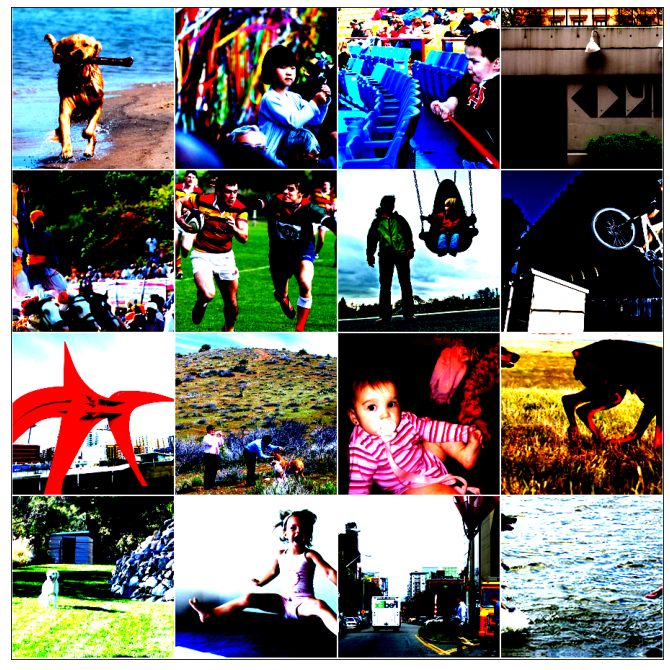

In [ ]:
show_batch(train_dl)

# Modelling 

As illustrated earlier, our model is going to consist of an Encoder architecture and a decoder Architecture.

The encoder RNN is going to be a pretrained model, ResNet152. The original paper 'Show and Tell' has been implemented using VGG16. 

**Note**: ResNet has been chosen based on the facts given the article linked [here.](https://cv-tricks.com/cnn/understand-resnet-alexnet-vgg-inception/)

There's also an interesting explanation available on this [here.](https://stats.stackexchange.com/questions/280179/why-is-resnet-faster-than-vgg/280338)

In [ ]:
torch.cuda.is_available()

True

We define a helper function to make sure that our model uses GPU if available, else CPU.

In [ ]:
device = get_default_device()
device

device(type='cuda')

The code below illustrates how we can load a batch of data from training set to our available device.

In [ ]:
for images, captions, lengths in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 3, 224, 224])
cuda:0


Next we'll define the model and then move it to the device.

We set the training parameters beforehand.

In [ ]:
# Size of the embedding layer
embed_size = 256

# number of features in hidden state of the RNN decoder 
hidden_size = 512

# Number of layers in the LSTM
num_layers = 1

# Learning rate
learning_rate = 0.001  # lr_scheduler.StepLR can be used to get the best learning_rate

# Number of epochs
num_epochs = 6

# time-step defining when to print the epoch summary
time_step = 60

# Size of vocab file
vocab_size = len(map)

# Path to save checkpoints
model_path= root + "models/"

In [ ]:
model = models.resnet152()

In [ ]:
model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

A short into about ResNet architecture. Unlike the other pre-trained models, ResNet has a residual blockto alleviate the effects of vanishing gradient during backpropagation. This unit’s structure is a feedforward network with a shortcut connection which adds new inputs into the network and generates new outputs. The main merit of this unit is that it produces better classification accuracy without increasing the complexity of the model. For more intuition on why ResNet works well, please check this [link.](https://cv-tricks.com/keras/understand-implement-resnets/)

So here, we consider the pre-trained model without the last fully connected layer.

In [ ]:
# Encoder class
class EncoderCNN(nn.Module):
  def __init__(self, embed_size):
    super(EncoderCNN, self).__init__()

    # Use pre-trained ResNet152 model
    resnet = models.resnet152(pretrained=True) 

    # Remember to set the gradients to False. We do not want to apply back-propagation to the pre-trained model
    for param in resnet.parameters():
            param.requires_grad_(False)
    
    # Omitting the last layer of the model
    layers = list(resnet.children())[:-1]

    # Unpack the layers
    self.resnet = nn.Sequential(*layers)

    """ The last layer of the encoder should be of the size that is compatible with our decoder's first layer.

        The decoder architechture starts with the attention layer followed by the embedding layer and LSTM.
        
        So we set resize the output of the last fully connected layer to match the embed_size
    """

    # Set the embed_size as FC's output size
    self.linear = nn.Linear(resnet.fc.in_features, embed_size) 

    #Batch normalization to speed up training
    self.bn = nn.BatchNorm1d(embed_size, momentum=0.01) # Weight normalization can also be tried instead

  def forward(self, images):
    """ Forward propagation to extract 2048-dimensional vector in the latent space """
    features = self.resnet(images)
    
    # Reshape the feature vector
    features = features.view(features.size(0), -1)

    # Pass the features to the linear layer
    features = self.linear(features)

    # Apply batch normalization
    out_vector = self.bn(features)

    return out_vector   

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # Embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
             
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)

        # Pack_padded_sequence() opti,izes the computations in RNN 
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 

        hiddens, _ = self.lstm(packed) 
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        predicted_sentence  = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hidden, states = self.lstm(inputs, states)          # hidden : (batch_size, 1, hidden_size)
            outputs = self.linear(hidden.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            predicted_sentence.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        predicted_sentence = torch.stack(predicted_sentence, 1)                # sampled_ids: (batch_size, max_seq_length)
        return predicted_sentence 

In [ ]:
# Initialize the encoder and decoder and move to device
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

In [ ]:
# Specify what parameters to be optimized
""" Parameters of the decoder, last layer if the pretrained model and the Batch normalization layer 
    of the encoder """
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())


# optimizer
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [ ]:
loss_lstm = []

encoder.train()
decoder.train()

if not os.path.exists(model_path):
    os.makedirs(model_path)

# before training
torch.save(encoder.state_dict(), os.path.join(model_path, 'CNN-encoder-0.ckpt'))
torch.save(decoder.state_dict(), os.path.join(model_path, 'LSTM-decoder-0.ckpt'))


In [ ]:
# Train the models

since = time.time()
total_step = len(train_dl)
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(train_dl):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = F.cross_entropy(outputs, targets)
        
        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        optimizer.step()

        # Print log info
        if i % time_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 
    loss_lstm.append(loss.item())
    torch.save(decoder.state_dict(), os.path.join(model_path, 'LSTM-decoder-{}.ckpt'.format(epoch+1)))
    torch.save(encoder.state_dict(), os.path.join(model_path, 'CNN-encoder-{}.ckpt'.format(epoch+1)))

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

print('Finished')

Epoch [0/6], Step [0/301], Loss: 8.1427, Perplexity: 3438.1465
Epoch [0/6], Step [60/301], Loss: 4.3561, Perplexity: 77.9558
Epoch [0/6], Step [120/301], Loss: 3.8710, Perplexity: 47.9908
Epoch [0/6], Step [180/301], Loss: 3.6965, Perplexity: 40.3076
Epoch [0/6], Step [240/301], Loss: 3.6682, Perplexity: 39.1796
Epoch [0/6], Step [300/301], Loss: 3.4908, Perplexity: 32.8137
Epoch [1/6], Step [0/301], Loss: 3.2941, Perplexity: 26.9535
Epoch [1/6], Step [60/301], Loss: 3.3089, Perplexity: 27.3540
Epoch [1/6], Step [120/301], Loss: 3.0794, Perplexity: 21.7453
Epoch [1/6], Step [180/301], Loss: 3.1919, Perplexity: 24.3338
Epoch [1/6], Step [240/301], Loss: 3.0582, Perplexity: 21.2901
Epoch [1/6], Step [300/301], Loss: 3.0488, Perplexity: 21.0897
Epoch [2/6], Step [0/301], Loss: 2.9525, Perplexity: 19.1529
Epoch [2/6], Step [60/301], Loss: 2.8597, Perplexity: 17.4566
Epoch [2/6], Step [120/301], Loss: 2.8318, Perplexity: 16.9760
Epoch [2/6], Step [180/301], Loss: 2.8609, Perplexity: 17.4770

In [ ]:
loss_lstm

[3.49084734916687,
 3.0487828254699707,
 2.573561668395996,
 2.7592735290527344,
 2.7129225730895996,
 2.5079312324523926]

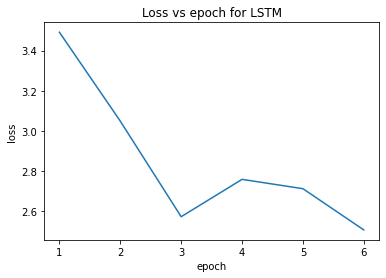

In [ ]:
plot_loss(loss_lstm)

Here we observe that the loss sees a minimum at epoch 3. We have added Perplexity here which is actually a measure of uncertainty in predicting the correct set of words for our caption. Lower the perplexity, the better it is. Mathematically, it is the exponential of entropy.

For more info on what perplexity is, please refer these [link1](https://www.cs.yale.edu/homes/radev/nlpclass/slides2017/213.pdf), [link2](https://leimao.github.io/blog/Entropy-Perplexity/)


Let's evaluate the model at Checkpoint 3 on some sample images.


In [ ]:
# Sample 3 images at random from test set. Note than the samples in validation set starts from index 38444
valid_df.head()

torch.manual_seed(0)
# Randomly pick 3 rows from valid_df
sampled_imgs = valid_df.sample(3)['image'].to_list()


['799486353_f665d7b0f0.jpg',
 '823675317_b5fbdb17b3.jpg',
 '874665322_9ad05c4065.jpg']

In [ ]:
sampled_imgs

['808245064_8a7971fc5b.jpg',
 '661755629_602ea4cf09.jpg',
 '70995350_75d0698839.jpg']

In [ ]:
def loadImage(image_path, transform=valid_txms):
    image = Image.open(image_path)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

image1 = loadImage(image_dir + sampled_imgs[0], valid_txms)
image2 = loadImage(image_dir + sampled_imgs[1], valid_txms)
image3 = loadImage(image_dir + sampled_imgs[2], valid_txms)
img_id1 = sampled_imgs[0]
img_id2 = sampled_imgs[1]
img_id3 = sampled_imgs[2]

In [ ]:
# Evaluation phase

# We start with a our choice of the checkpoint initially
# this is to see if the checkpoint corresponding ti lowest loss is overfitting
# Load the encoder-decoder model with the lowest loss for now

encoder_file_path = os.path.join(model_path, 'CNN-encoder-{}.ckpt'.format('5'))
decoder_file_path = os.path.join(model_path, 'LSTM-decoder-{}.ckpt'.format('5'))

# Initialize the encoder and decoder and set it to evaluation mode
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, len(map), num_layers)


# Load the trained weights.
encoder.load_state_dict(torch.load(encoder_file_path))
decoder.load_state_dict(torch.load(decoder_file_path))


encoder.eval()
decoder.eval()

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

# Move image1, image2 and image3 to device
image1 = image1.to(device)
image2 = image2.to(device)
image3 = image3.to(device)

# Predicted and actual captions
predicted, actual = list(), list()


 Generated Caption:  man in black shirt and sunglasses is holding up sign
 Actual caption(s): 
 dark skinned man smoking  cigarette near  green trashcan 
 man in  blue shirt is standing outside smoking  cigarette 
 man in  blue shirt smoking  cigarette
 man stands outside smoking  cigarette
 man with glasses smokes  cigarette 




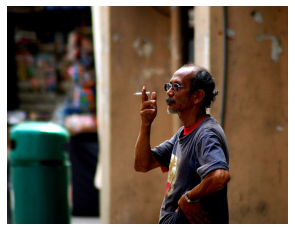

In [ ]:
generate_caption(image1, img_id1)

 Generated Caption:  dog runs through the grass
 Actual caption(s): 
 black and brown dog with  red ball overhead plays in the grass 
 little dog is looking at  red ball 
 little furry dog playing with  red ball in  forest
 small dog tries to catch  red ball 
this tiny dog is about to jump in the air to catch  red ball 




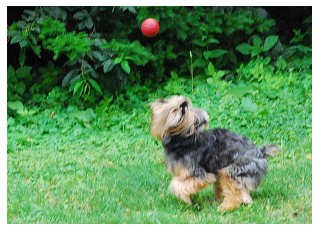

In [ ]:
generate_caption(image2, img_id2)

 Generated Caption:  man is surfing on the beach
 Actual caption(s): 
 kite surfer is doing  flip over the waves 
 man jumps over  wave on his surfboard 
 person on  parasail jumps off  wave 
 silver craft rides the waves 
 windsurfer angles over  wave 




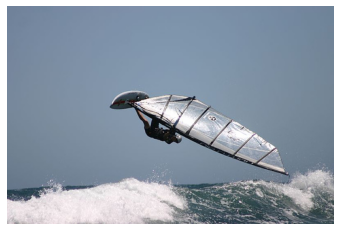

In [ ]:
generate_caption(image3, img_id3)

 Generated Caption:  man in blue shorts is standing on the beach
 Actual caption(s): 
 boy in blue carries  bucket 
 boy in blue swim trunks carries  blue bucket down  crowded beach 
 child walks on the beach with  bucket 
the boy in the blue shorts is carrying  bucket on the beach 
young boy in blue shorts at the beach 




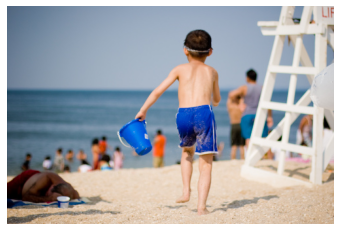

In [ ]:
random_image = loadImage(image_dir + '823675317_b5fbdb17b3.jpg', valid_txms)
generate_caption(random_image, '823675317_b5fbdb17b3.jpg')

Now, let's explore bleu_score from NLTK.

In [ ]:
# two words different
from nltk.translate.bleu_score import sentence_bleu
gen_cap = 'dog with its mouth open and is drinking the water'
tokenized_cap = []
tokenized_cap.append(gen_cap.split())
actual_cap = 'dog drinking water'
tokenized_actual = actual_cap.split()
tokenized_cap = [['dog','is','drinking','the','water']]
actual_cap = ['dog', 'drinks', 'water']

In [ ]:
score = sentence_bleu(tokenized_cap, actual_cap, weights=(0.25, 0.25, 0.25,0.25))
print(score)

0.4639247374454443


The following code has been adopted from the GitHub reporitory of **Hurley James** which is helpful in comparing which of the trained checkpoints are doing well in generating meaningful captions.

In [ ]:
# Function to transform index to words
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
def transform_idx_to_words(input):
    sampled_caption = []

    for idx in input:
        word = map.idx2word[idx]
        sampled_caption.append(word)

        if word == '<end>':
            break
    
    output = ' '.join(sampled_caption[1:-1])
    output = output.replace(' ,', ',')
    
    return output.split(' ')

In [ ]:
epoch_checkpoint = ['0', '1', '2', '3', '4', '5', '6']


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

bleu_score1 = []
bleu_score2 = []
bleu_score3 = []

show1_captions = []
show2_captions = []
show3_captions = []


for model_name in range(len(epoch_checkpoint)):
    print(model_name)
    encoder_model_path = os.path.join(model_path, 'CNN-encoder-{}.ckpt'.format(model_name))
    decoder_model_path = os.path.join(model_path, 'LSTM-decoder-{}.ckpt'.format(model_name))

    test_encoder = EncoderCNN(embed_size)
    test_decoder = DecoderRNN(embed_size, hidden_size, len(map), num_layers)    

    test_encoder.load_state_dict(torch.load(encoder_model_path))
    test_decoder.load_state_dict(torch.load(decoder_model_path))

    if torch.cuda.is_available():
        test_encoder = test_encoder.to(device)
        test_decoder = test_decoder.to(device)

    test_encoder.eval()
    test_decoder.eval()

    image1 = image1.to(device)
    image2 = image2.to(device)
    image3 = image3.to(device)


    predicted, actual = list(), list()
    predicted_total, actual_total = list(), list()    


    feature1 = test_encoder(image1)
    cap1 = test_decoder.sample(feature1)
    cap1 = cap1.cpu().data.numpy()


    feature2 = test_encoder(image2)
    cap2 = test_decoder.sample(feature2)
    cap2 = cap2.cpu().data.numpy()

    feature3 = test_encoder(image3)
    cap3 = test_decoder.sample(feature3)
    cap3 = cap3.cpu().data.numpy()


    predicted.append(cap1)
    predicted.append(cap2)
    predicted.append(cap3)

    predicted1 = " ".join(transform_idx_to_words(predicted[0][0,:]))
    predicted2 = " ".join(transform_idx_to_words(predicted[1][0,:]))
    predicted3 = " ".join(transform_idx_to_words(predicted[2][0,:]))

    # 1st image
    print("The generated caption of 1st image: " + predicted1)
    show1_captions.append(predicted1)

    # 2nd image
    print("The generated caption of 2nd image: " + predicted2)
    show2_captions.append(predicted2)
 
    # 3rd image
    print("The generated caption of 3rd image: " + predicted3)
    show3_captions.append(predicted3)

    print('done for model: {}'.format(model_name))

0
The generated caption of 1st image: hits guy shots swimmer stream stream fruit plain musicians ride happily ski support tank piggyback country squirted siting
The generated caption of 2nd image: ice home frames coffee rafts midst called snow turns bagpipe graffitied put partially walls guide jackets dresses shorthaired
The generated caption of 3rd image: tutu support squat out ski balck unknown traverses pops out cross reading tops moustache musicians reaching guitar arrow
done for model: 0
1
The generated caption of 1st image: man in red shirt and woman is standing in front of <unk>
The generated caption of 2nd image: two dogs are running through the grass
The generated caption of 3rd image: man in red shirt is riding bike on the beach
done for model: 1
2
The generated caption of 1st image: man in black shirt is holding up sign
The generated caption of 2nd image: black dog is running through the grass
The generated caption of 3rd image: the man is wearing black and white dog is jump

Clearly, the model before training perfomed very badly. Hence we remove the prediction from checkpoint-0. 


In [ ]:
show1_captions

['hits guy shots swimmer stream stream fruit plain musicians ride happily ski support tank piggyback country squirted siting',
 'man in red shirt and woman is standing in front of <unk>',
 'man in black shirt is holding up sign',
 'man in blue shirt and tie is holding up sign',
 'man in black shirt is holding up sign that says <unk>',
 'man in black shirt and sunglasses is holding up sign',
 'man in blue shirt and sunglasses is standing in front of an <unk> <unk>']

In [ ]:
# Actual captions for image 1
actual_img1 = descriptions[img_id1]
actual_img1

[' dark skinned man smoking  cigarette near  green trashcan ',
 ' man in  blue shirt is standing outside smoking  cigarette ',
 ' man in  blue shirt smoking  cigarette',
 ' man stands outside smoking  cigarette',
 ' man with glasses smokes  cigarette ']

In [ ]:
captions_img1 = show1_captions[1:6]

bleu4_img1 = []
for i in range(len(captions_img1)):
  score = sentence_bleu(captions_img1[i], actual_img3[i] , weights=(0.25, 0.25, 0.25, 0.25))
  j = i+1
  bleu4_img1.append((j,round(score,2)))
  print(f"BLEU score for model {j}: {score}")

BLEU score for model 1: 0.7810213065790322
BLEU score for model 2: 0.7598356856515925
BLEU score for model 3: 0.7546487907970829
BLEU score for model 4: 0.7598356856515925
BLEU score for model 5: 0.7952707287670506


Below are the BLEU scores for captions generated for image 2 and image 3 samples. Note that we are testing BLEU score only for models 1 through 5.

In [ ]:
show2_captions

['ice home frames coffee rafts midst called snow turns bagpipe graffitied put partially walls guide jackets dresses shorthaired',
 'two dogs are running through the grass',
 'black dog is running through the grass',
 'dog running through the grass',
 'dog runs through the grass',
 'black and white dog is running through the grass',
 'small dog runs through field']

In [ ]:
# Actual captions for image 2
actual_img2 = descriptions[img_id2]
actual_img2

[' black and brown dog with  red ball overhead plays in the grass ',
 ' little dog is looking at  red ball ',
 ' little furry dog playing with  red ball in  forest',
 ' small dog tries to catch  red ball ',
 'this tiny dog is about to jump in the air to catch  red ball ']

In [ ]:
captions_img2 = show2_captions[1:6]

bleu4_img2 = []
for i in range(len(captions_img2)):
  score = sentence_bleu(captions_img2[i], actual_img2[i] , weights=(0.25, 0.25, 0.25, 0.25))
  j = i+1
  bleu4_img2.append((j,round(score,2)))
  print(f"BLEU score for model {j}: {score}")

BLEU score for model 1: 0.6713374035706625
BLEU score for model 2: 0.7896895367562644
BLEU score for model 3: 0.7105477917053864
BLEU score for model 4: 0.7259795291154771
BLEU score for model 5: 0.7156448279220523


In [ ]:
# Let candidate be the generated caption for model 3 image 2
candidate = show2_captions[3].split()
print('Caption generated for Image 2: ', candidate)

# Actual captions for image 2
actual_img2 = descriptions[img_id2]
print('Actual captions for image 2: ',actual_img2)

# Image 2 bleu 4 scores
candidate = show2_captions[3].split()
bleu4_img2 = []
for i in range(len(actual_img2)):
  score = sentence_bleu(candidate, actual_img2[i] , weights=(0.25, 0.25, 0.25, 0.25))
  j = i+1
  bleu4_img2.append((j,round(score,2)))
  print(f"BLEU score for model 3 candidate w.r.t actual captions for image 2: {score}")

Caption generated for Image 2:  ['dog', 'running', 'through', 'the', 'grass']
Actual captions for image 2:  [' black and brown dog with  red ball overhead plays in the grass ', ' little dog is looking at  red ball ', ' little furry dog playing with  red ball in  forest', ' small dog tries to catch  red ball ', 'this tiny dog is about to jump in the air to catch  red ball ']
BLEU score for model 3 candidate w.r.t actual captions for image 2: 0.09958921354772332
BLEU score for model 3 candidate w.r.t actual captions for image 2: 0.2078787665206437
BLEU score for model 3 candidate w.r.t actual captions for image 2: 0.17959811450842098
BLEU score for model 3 candidate w.r.t actual captions for image 2: 0.15053701656385038
BLEU score for model 3 candidate w.r.t actual captions for image 2: 0.16991622545192941


In [ ]:
show3_captions

['tutu support squat out ski balck unknown traverses pops out cross reading tops moustache musicians reaching guitar arrow',
 'man in red shirt is riding bike on the beach',
 'the man is wearing black and white dog is jumping over the water',
 'man in blue wetsuit is surfing on the beach',
 'the man is in the air on the beach',
 'person in blue and white suit is skiing down the hill',
 'man is in the water']

In [ ]:
# Actual captions for image 3
actual_img3 = descriptions[img_id3]
actual_img3

[' kite surfer is doing  flip over the waves ',
 ' man jumps over  wave on his surfboard ',
 ' person on  parasail jumps off  wave ',
 ' silver craft rides the waves ',
 ' windsurfer angles over  wave ']

In [ ]:
captions_img3 = show3_captions[1:6]

bleu4_img3 = []
for i in range(len(captions_img3)):
  score = sentence_bleu(captions_img3[i], actual_img3[i] , weights=(0.25, 0.25, 0.25, 0.25))
  j = i+1
  bleu4_img3.append((j,round(score,2)))
  print(f"BLEU score for model {j}: {score}")

BLEU score for model 1: 0.7415129228605242
BLEU score for model 2: 0.8125424861344327
BLEU score for model 3: 0.7699019277569183
BLEU score for model 4: 0.7400828044922853
BLEU score for model 5: 0.8113449257895087


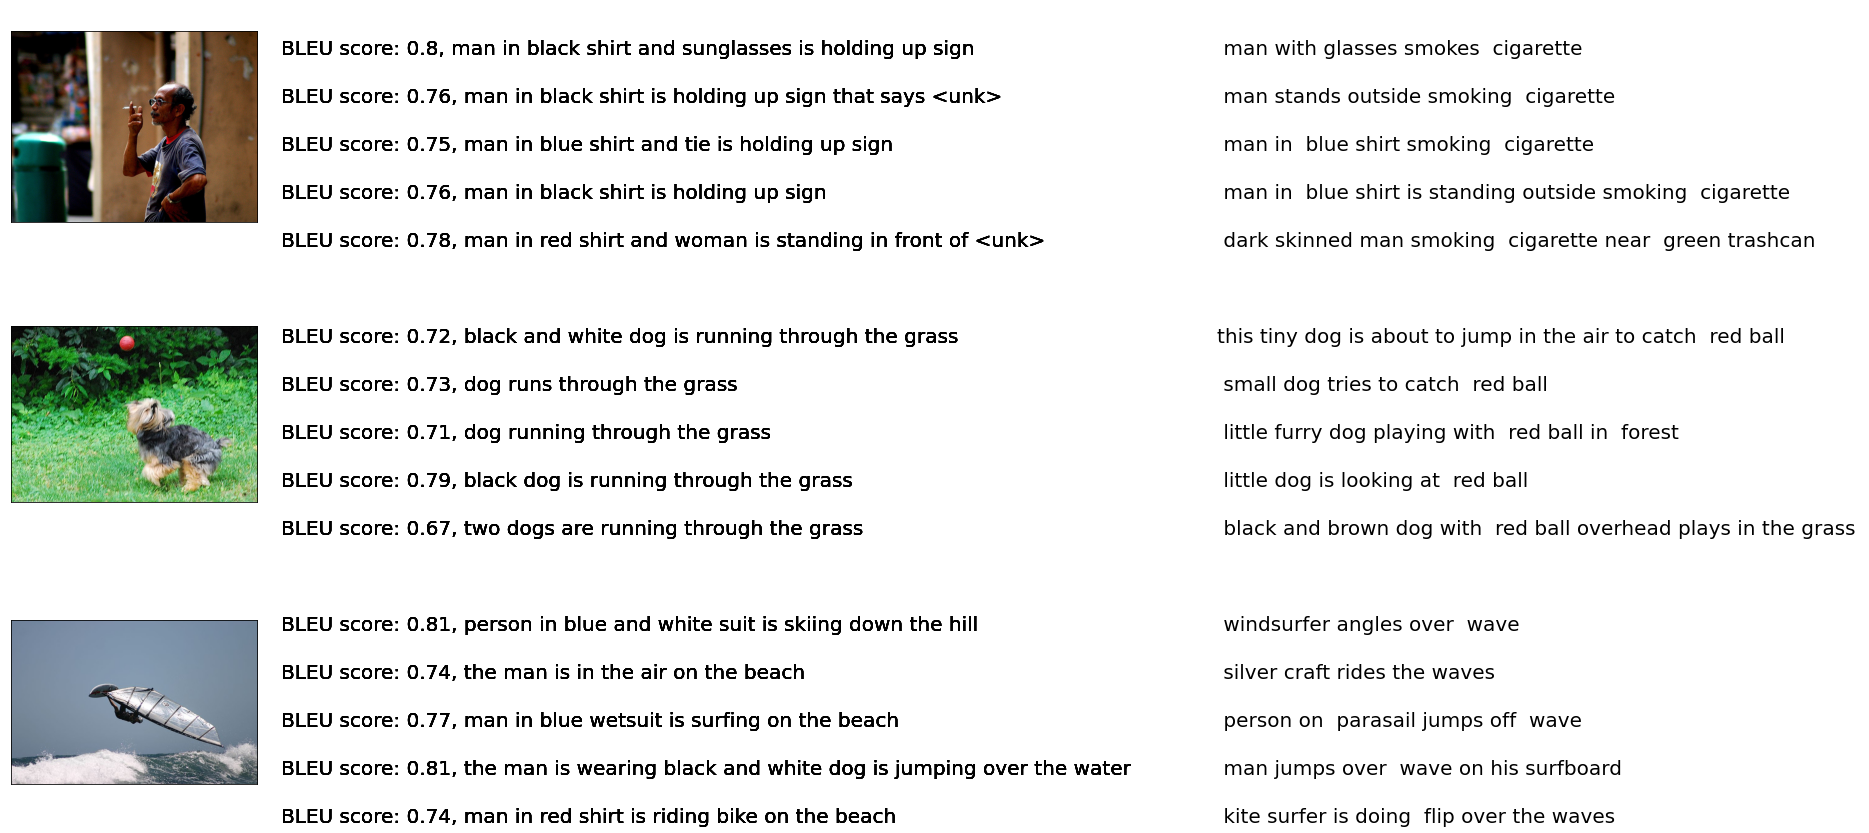

In [ ]:
# Visualizing the generated captions and the actual captions
show_image_and_captions(sampled_imgs, captions, n_cols = 3, out_flag = True)

Are you interested in more results? The output given below was generated from another batch of sample images.




![Additional results from the model](https://docs.google.com/uc?export=download&id=1vuv3JeFEvpaMfgmki65fBQMzk2EJlGYY)



**This is another sample image**


![alt text](https://docs.google.com/uc?export=download&id=1DJZgcxRJKQiVo_5TaWuNJSMHwyFshSuv)


# Conclusion

Here comes the end of our experiment with Image Captioning with PyTorch. 

**Future work**

1) Use of pre-trained word embeddings instead of building vocabulary

2) Use of Visual Attention mechanism to improve the caption quality

3) Use of Transformers such as BERT for the language modelling part

4) More fine tuning by adding layers to the pre-trained model to improve object recognition.


*To be continued ...*

# References:

[PyTorch Tutorials by Yunjey](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning)

[Torchtext - Getting started](https://github.com/mjc92/TorchTextTutorial/blob/master/01.%20Getting%20started.ipynb)

[pack_padded_sequences intuition and understanding](https://suzyahyah.github.io/pytorch/2019/07/01/DataLoader-Pad-Pack-Sequence.html)

Show and Tell: Neural Image Caption Generator [link](https://arxiv.org/abs/1411.4555)

